In [17]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression,Lasso, LassoCV
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import time

#read UCI data from Kaggle
data=pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')

In [18]:
#EDA
#print the summary of data
print(data.describe().T)
data.rename(columns={'default.payment.next.month':'def_value'}, inplace=True)
#print the number of null values in the data
print(data.isna().sum())

                              count           mean            std       min  \
ID                          30000.0   15000.500000    8660.398374       1.0   
LIMIT_BAL                   30000.0  167484.322667  129747.661567   10000.0   
SEX                         30000.0       1.603733       0.489129       1.0   
EDUCATION                   30000.0       1.853133       0.790349       0.0   
MARRIAGE                    30000.0       1.551867       0.521970       0.0   
AGE                         30000.0      35.485500       9.217904      21.0   
PAY_0                       30000.0      -0.016700       1.123802      -2.0   
PAY_2                       30000.0      -0.133767       1.197186      -2.0   
PAY_3                       30000.0      -0.166200       1.196868      -2.0   
PAY_4                       30000.0      -0.220667       1.169139      -2.0   
PAY_5                       30000.0      -0.266200       1.133187      -2.0   
PAY_6                       30000.0      -0.291100  

It indicates there is no missing values in this data.

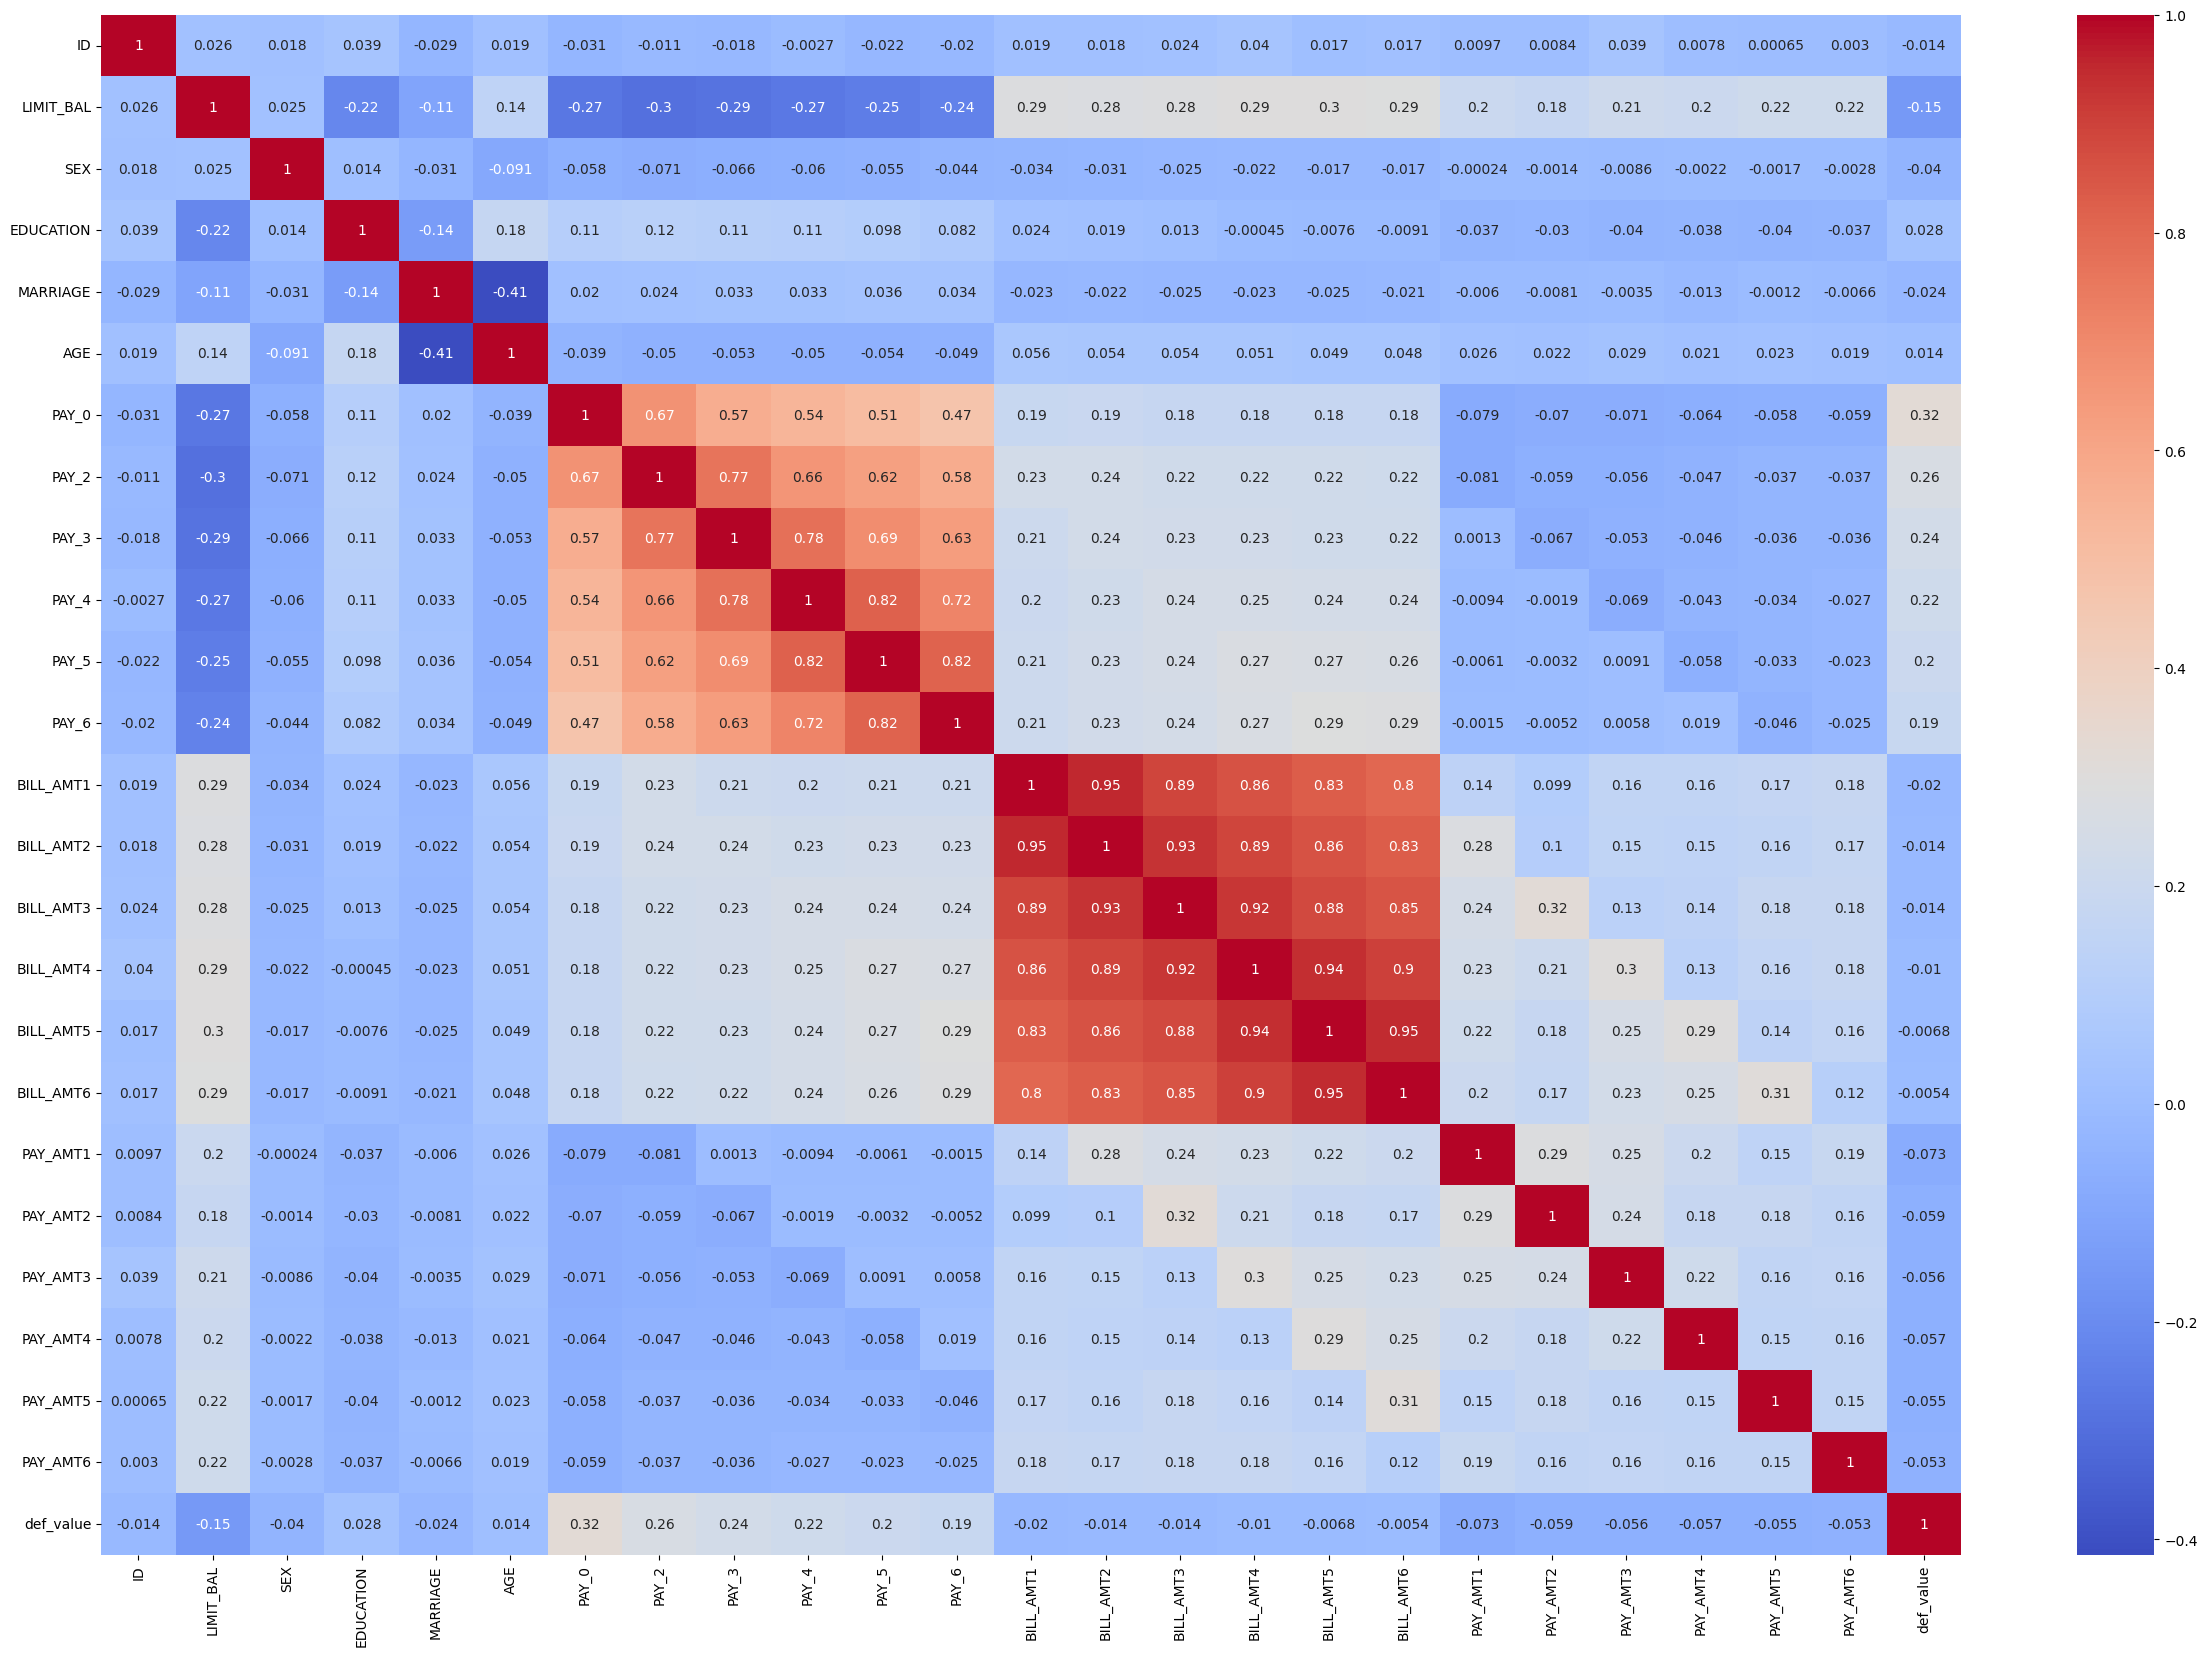

In [19]:
#draw the heatmap of the correlation between the variables
plt.subplots(figsize=(30,20))
sns.heatmap(data.corr(),annot=True,cmap='coolwarm')
plt.show()

We can see that the correlation between PAY** varaibles, BILL_Amount** is high. Others are low.

In [20]:
count_def=data.def_value.value_counts(normalize=True)*100
print(count_def)

def_value
0    77.88
1    22.12
Name: proportion, dtype: float64


We can see that 78% of the data are non_default and 22% of the data are default.

In [21]:
data_x=data.drop(['def_value','ID'], axis=1)
data_y=data.def_value

model1_LR = LogisticRegression(max_iter=10000)
fold_10=KFold(n_splits=10,shuffle=True,random_state=40)
results_model1=cross_val_score(model1_LR,data_x,data_y,cv=fold_10)
print("Accuracy: %.2f%% (%.2f%%)" % (results_model1.mean()*100, results_model1.std()*100))



##print(classification_report(y_pred, y_test))
#print(sk.metrics.confusion_matrix(y_pred, y_test))
#print('\nAccuracy Score for model1: ', sk.metrics.accuracy_score(y_pred,y_test))

Accuracy: 77.87% (0.62%)


The logistic regression result without feature selection and feature scaling.
The 10-fold accuracy is 77.87%

In [22]:
model2_xgb=XGBClassifier(max_depth=2, n_estimators=10, learning_rate=0.1, eval_metric='logloss')
results_model2=cross_val_score(model2_xgb,data_x,data_y,cv=fold_10,scoring='accuracy')
print("Accuracy: %.2f%% (%.2f%%)" % (results_model2.mean()*100, results_model2.std()*100))

Accuracy: 81.99% (0.86%)


We can see that the result of XGBoost is 81.99%.
We will know conduct feature selection and feature engineering like scaling and decoding.

In [23]:
#Scale the data to mean=0 and SE=1
scaler=StandardScaler()
data_x_scaled=scaler.fit_transform(data_x)
#no need to do scaling for y because it is category.

In [24]:
#Use Lasso to do feature selection, first determine the best alpha
lasso_cv=LassoCV(alphas=np.logspace(-4, 3, 10000),cv=10)
lasso_cv.fit(data_x_scaled,data_y)

LassoCV(alphas=array([1.00000000e-04, 1.00161327e-04, 1.00322914e-04, ...,
       9.96781250e+02, 9.98389328e+02, 1.00000000e+03]),
        cv=10)

In [25]:
feature_mask = lasso_cv.coef_ != 0
selected_features=data_x.columns[feature_mask].tolist()
print(selected_features)

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


We can see that the selected feature names by Lasso are 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'

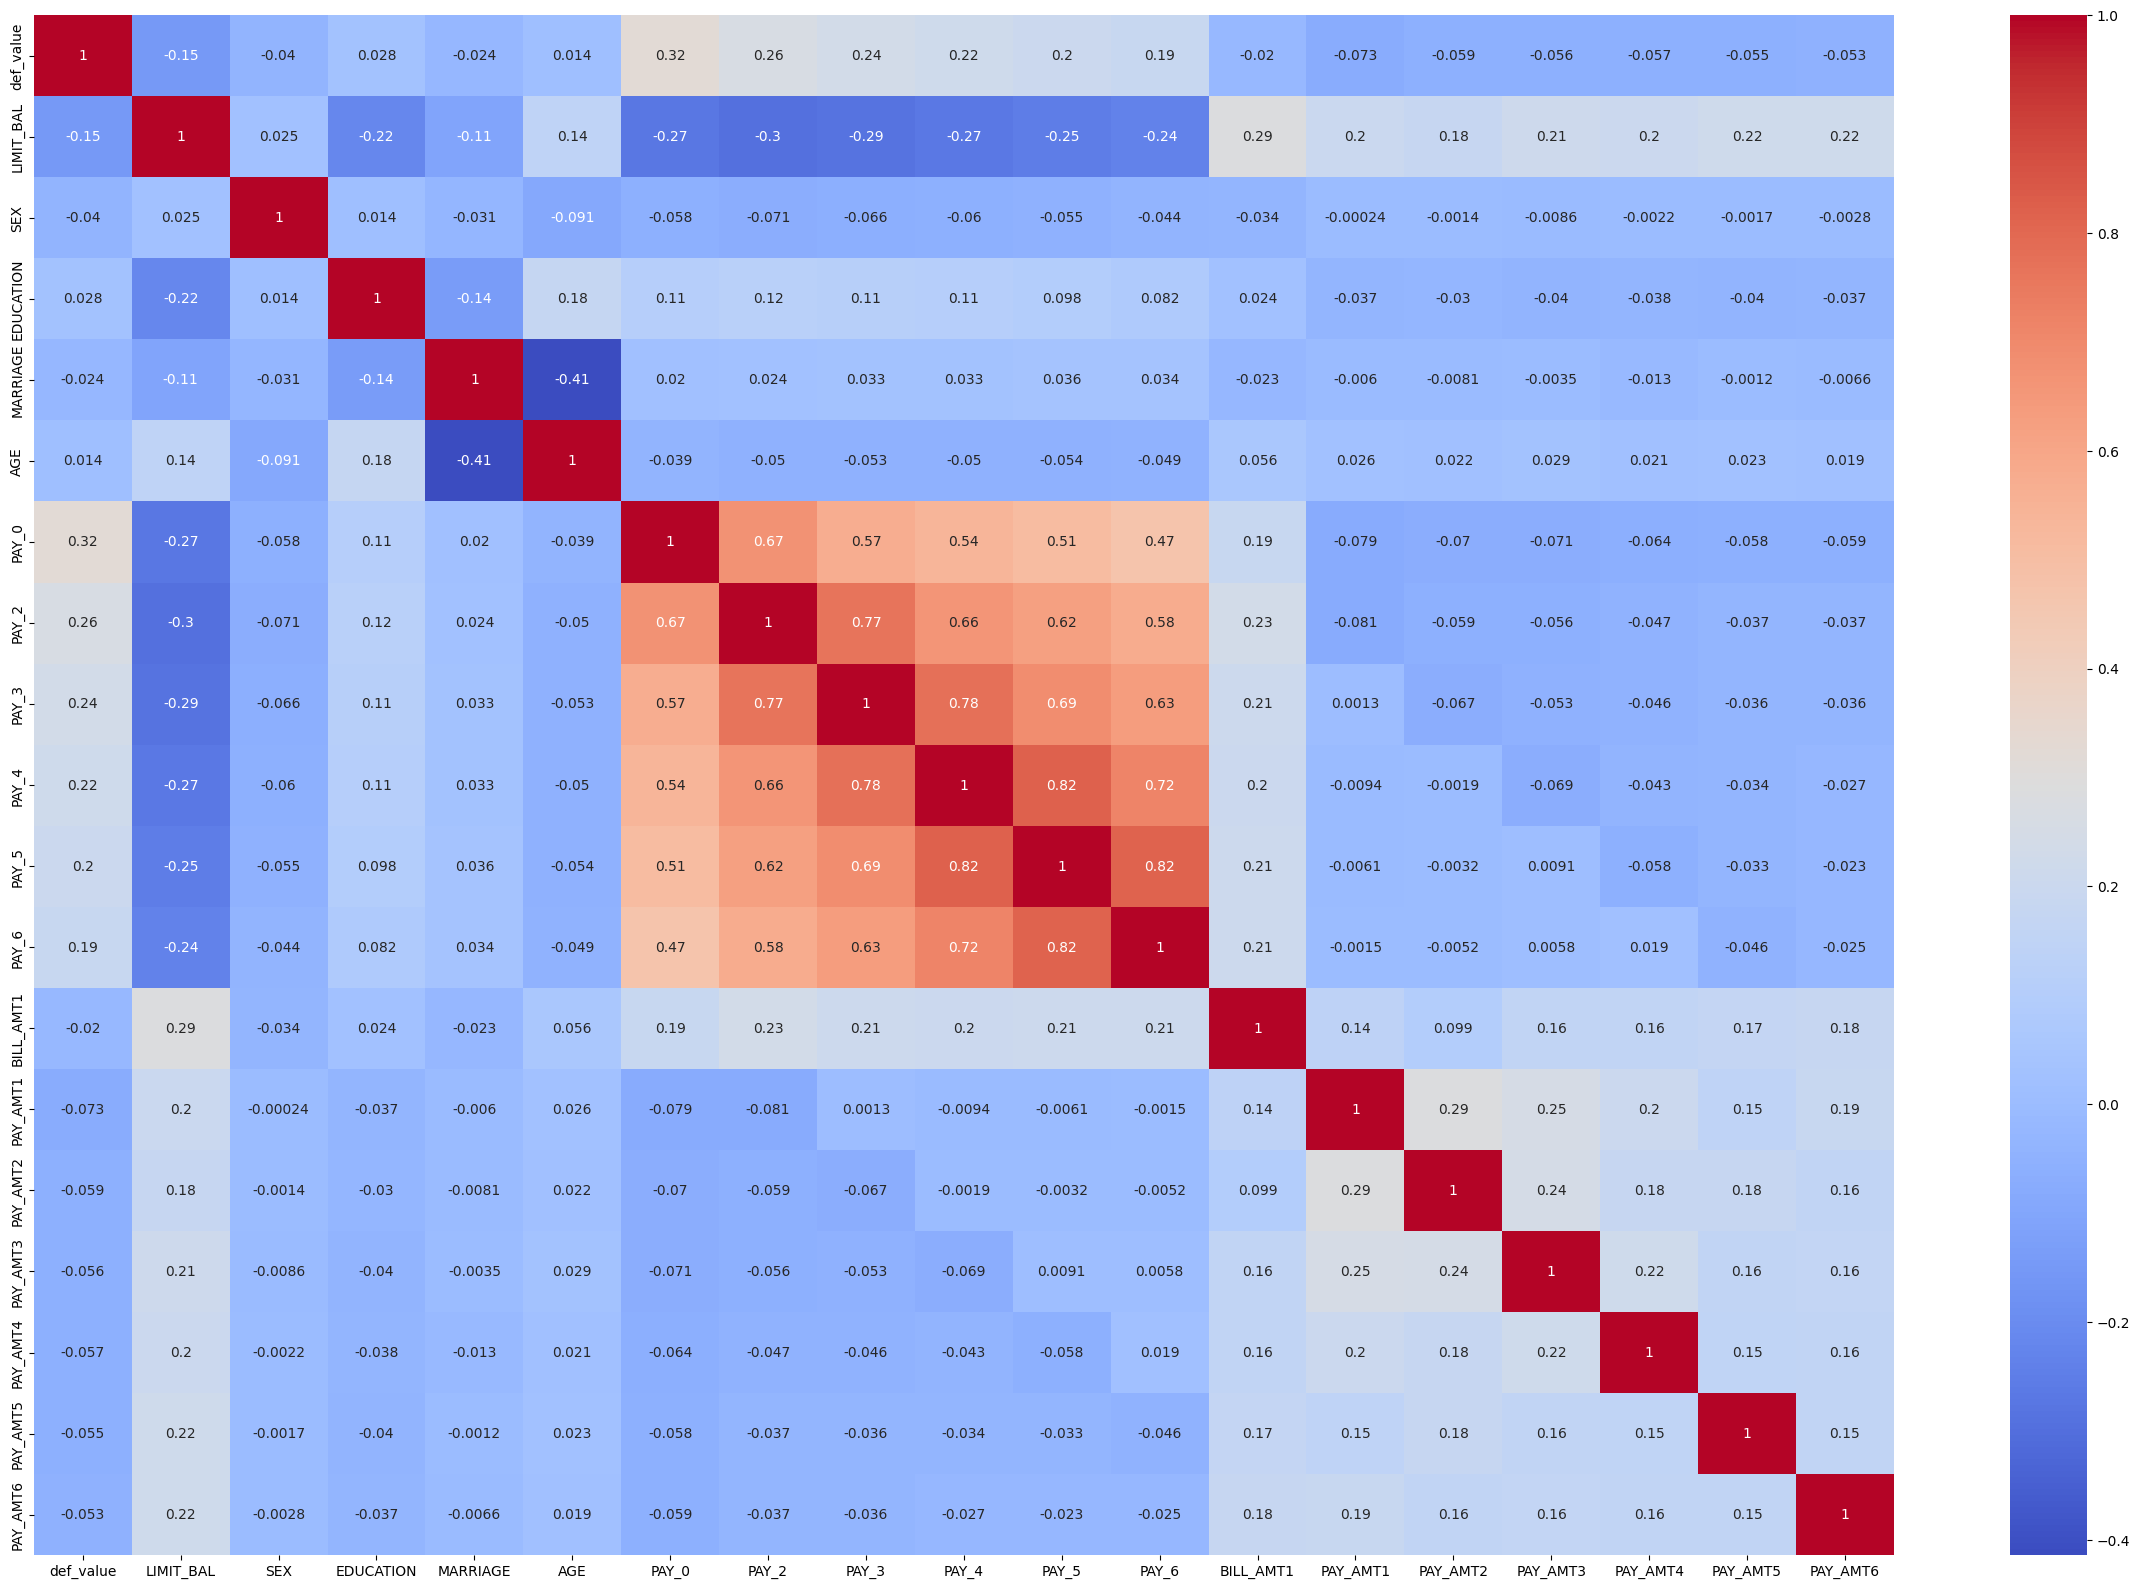

In [26]:
#create new predicator data based on select features
selectedF_data_x=data_x.loc[:,feature_mask]
#plot the correlation between the new variables
combined_data=pd.concat([data_y,selectedF_data_x],axis=1)
plt.subplots(figsize=(30,20))
sns.heatmap(combined_data.corr(),annot=True,cmap='coolwarm')
plt.show()

#scale the new data to mean=0 and SE=1
scaler=StandardScaler()
selectedF_data_x_scaled=scaler.fit_transform(selectedF_data_x)

We can see that the correlation between predicators have been reduced.
Now we will use selected features to train the model.

In [27]:
#XGBoost
model3_xgb=XGBClassifier(max_depth=2, n_estimators=10, learning_rate=0.1, eval_metric='logloss')
results_model3=cross_val_score(model3_xgb,selectedF_data_x_scaled,data_y,cv=fold_10,scoring='accuracy')
print("Accuracy: %.2f%% (%.2f%%)" % (results_model3.mean()*100, results_model3.std()*100))

Accuracy: 81.99% (0.86%)


In [28]:
#Logistic Regression
start_time=time.perf_counter()
model4_LR = LogisticRegression(max_iter=10000)
fold_10=KFold(n_splits=10,shuffle=True,random_state=40)
results_model4=cross_val_score(model4_LR,selectedF_data_x_scaled,data_y,cv=fold_10)
end_time=time.perf_counter()
timecost=end_time-start_time
print("Accuracy: %.2f%% (%.2f%%)" % (results_model4.mean()*100, results_model4.std()*100))
print(f"Time cost: {timecost} seconds")

Accuracy: 80.97% (0.78%)
Time cost: 0.8737618099999054 seconds


After conducting the feature selection(by Lasso) and scaling. The accuracy for Losgistic Regression has increased from 77.87% to 80.97%, and that of XGBoost increased from 81.99% to 82.17%. This is mainly because Logistic Regression relay on feature selection but XGBoost can shrink the features by itself, so the feature selection has less effect on XGBoost than Logistic Regression. 

Next we will do CV to determine the hyperparameters for XGBoost.

In [33]:
#select the hyperparameter of XGBoost
xgb_model_set = XGBClassifier()
param_dist = {
    'max_depth': randint(3,10),
    'learning_rate': uniform(0.01,0.2),
    'n_estimators': randint(100,300),
    'subsample':uniform(0.8,0.2)
}
random_search=RandomizedSearchCV(estimator=xgb_model_set,param_distributions=param_dist,n_iter=50,cv=10,scoring='accuracy',verbose=1)
random_search.fit(selectedF_data_x_scaled,data_y)

print(random_search.best_params_)
print(random_search.best_score_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
{'learning_rate': 0.041565134097084726, 'max_depth': 3, 'n_estimators': 162, 'subsample': 0.9665240310129963}
0.8220333333333334


In [38]:
best_params=random_search.best_params_
#XGBoost with the best hyperparameters
start_time=time.perf_counter()
model5_xgb=XGBClassifier(max_depth=best_params['max_depth'],n_estimators=best_params['n_estimators'],learning_rate=best_params['learning_rate'],subsample=best_params['subsample'],eval_metric='logloss')
results_model5=cross_val_score(model5_xgb,selectedF_data_x_scaled,data_y,cv=fold_10,scoring='accuracy')
end_time=time.perf_counter()
timecost=end_time-start_time
print("Accuracy: %.2f%% (%.2f%%)" % (results_model5.mean()*100, results_model5.std()*100))
print(f"Time cost: {timecost} seconds")

Accuracy: 82.19% (0.77%)
Time cost: 5.043828054999722 seconds


We can see by using the best hyperparameters the accuracy increased by 0.2%.